### Factors Driving Life Expectancy : Do immunization matters?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
#MICE performe multiple regression for imputing / it is a very robost model for imputation
from fancyimpute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,  f_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
import xgboost as xgb

import os

from library.sb_utils import save_file

In [3]:
sns.set()
sns.set_context("notebook")

### Import dataset 

In [4]:
df1 = pd.read_csv("../data/life_exp_clean.csv")

In [5]:
# convert Year to datetime object 
df1.Year = pd.to_datetime(df1.Year, format='%Y-%d-%m')
df1['year']=df1['Year'].dt.year

### Label Encoder categerical variable

In [6]:
# copy the data
df = df1.copy(deep=True)

In [7]:
df = df.drop(columns='Country')

In [8]:
# one hot_encoder
df = pd.get_dummies(df)
df.insert(0,'Country', df1['Country'], allow_duplicates=True)

In [9]:
df.columns

Index(['Country', 'Year', 'Life_expectancy', 'Adult_Mortality',
       'infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'under_five_deaths', 'Polio', 'Total_expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness__1_19_years',
       'thinness_5_9_years', 'Income_composition_of_resources', 'Schooling',
       'year', 'population', 'Status_Developed', 'Status_Developing'],
      dtype='object')

In [10]:
columns = ['Country', 'Year', 'Adult_Mortality',
       'infant_deaths', 'Alcohol', 'percentage_expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'under_five_deaths', 'Polio', 'Total_expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness__1_19_years',
       'thinness_5_9_years', 'Income_composition_of_resources', 'Schooling',
       'year', 'Status_Developed', 'Status_Developing']
# define X and y
X = df[columns]
y = df[['Life_expectancy']]

In [11]:
# split the dataset     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

In [12]:
# save name
names_list = ['Country','Year', 'year']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


((2342, 20), (586, 20))

In [13]:
# traitement of missing data with MICE Imputation
mice_imputer = IterativeImputer()
X_train_imput = mice_imputer.fit_transform(X_train)
X_test_imput = mice_imputer.fit_transform(X_test)

In [14]:
# scale the date
scaler = StandardScaler()
X_train_imput_scale = scaler.fit_transform(X_train_imput)
X_test_imput_scale = scaler.fit_transform(X_test_imput)

In [15]:
# dimentionnality reduction
pca = PCA()
X_train_pca = pca.fit(X_train_imput_scale)

In [16]:
X_train_pcat = pca.transform(X_train_imput_scale)

###  Modeling


##### Function to evaluate the model

In [17]:
def model_eval(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

### 1. Model linear_regression 

In [18]:
pipe = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [19]:
# define the k range to investigate
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [20]:
reg_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=10, n_jobs=-1)

In [21]:
reg_grid_cv.fit(X_train, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001CF362A1550>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19,
                                            20]})

In [22]:
#Print the `best_params_` attribute of 'red_grid_cv`
reg_grid_cv.best_params_

{'selectkbest__k': 19}

In [23]:
score_mean = reg_grid_cv.cv_results_['mean_test_score']
score_std = reg_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in reg_grid_cv.cv_results_['param_selectkbest__k']]
best_k = reg_grid_cv.best_params_['selectkbest__k']

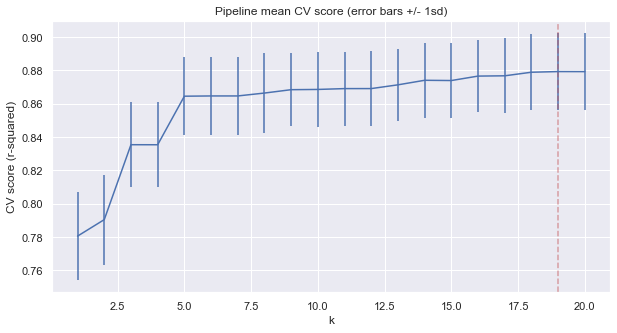

In [24]:
best_k = reg_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 19

In [25]:
# mask to select the most useful features 
selected_features= reg_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
selected_features

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True])

In [26]:
coefs = reg_grid_cv.best_estimator_.named_steps.linearregression.coef_[0]
features = X_train.columns[selected_features]
pd.Series(coefs, index=features).sort_values(ascending=False)

Income_composition_of_resources    7.494087
infant_deaths                      5.843963
percentage_expenditure             1.098906
Total_expenditure                  0.581314
Diphtheria                         0.294017
Polio                              0.271401
Status_Developed                   0.097650
Hepatitis_B                        0.077650
thinness__1_19_years               0.048061
Measles                           -0.050839
BMI                               -0.090439
thinness_5_9_years                -0.090793
Status_Developing                 -0.097650
Alcohol                           -0.585913
Schooling                         -1.045386
GDP                               -1.083616
Adult_Mortality                   -1.566916
HIV/AIDS                          -1.899545
under_five_deaths                 -6.034938
dtype: float64

#### Note:
From this result, the best positive features here are Income_composition_of_resources , followed by infant_deaths. 

Features which negatively influence life expectancy are under_five_deaths of children (the most important) , next it is HIV/AIDS and Adult_Mortality.

We realise that immunization factors are also present among the positive features (come in 6th , 7th and 8th positions) even if their strength is not high as compared to the first features. 

It is also important to highlight the fact that the feature: status of the country (either developed or developing) has an impact on the model. 
May, it would be great to expect if a dataset with only developing countries would highlight the importance of immunization as we explore in the EDA.


In [27]:
reg_grid_cv.best_estimator_

Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=19,
                             score_func=<function f_regression at 0x000001CF362A1550>)),
                ('linearregression', LinearRegression())])

In [28]:
lin_reg = reg_grid_cv.best_estimator_

In [29]:
#lin_reg.get_params()

In [30]:
#### a suprimer 
pipe2 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    SelectKBest(f_regression, k=19),
    LinearRegression())

#### Assess performance on train and test data

In [31]:
predicted_train = lin_reg.predict(X_train)
predicted_test = lin_reg.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.465613032612806
MSE: 11.791841090808283
RMSE: 3.4339250269637924
R2 Square 0.8681868881712305
__________________________________
MAE: 2.422440641833822
MSE: 10.751017484476902
RMSE: 3.278874423407658
R2 Square 0.8817694049560904
__________________________________


#### Assessing performance using cross-validation

In [32]:
cv_results = cross_validate(reg_grid_cv.best_estimator_, X_train, y_train, cv=5)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  re

In [33]:
cv_scores = cv_results['test_score']
np.mean(cv_scores), np.std(cv_scores)

(0.8796441263228804, 0.012124405235131887)

### 2. Model linear regression with PCA

In [34]:
pipe3 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    PCA(n_components=19),
    LinearRegression())

In [35]:
lin_reg2 = pipe3.fit(X_train, y_train)

In [36]:
#lin_reg2.get_params()

#### Model Evaluation

In [37]:
predicted_train = lin_reg2.predict(X_train)
predicted_test = lin_reg2.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.4646197667876497
MSE: 11.782041384887318
RMSE: 3.432497834651512
R2 Square 0.8682964325352108
__________________________________
MAE: 2.42219185750846
MSE: 10.749188467196356
RMSE: 3.2785955022229194
R2 Square 0.881789518940812
__________________________________


### 3. Model: Ridge regression 

In [38]:
###select the best value of alpha

In [39]:
# Perform 5-fold cross-validation: ridge_cv
alpha = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 20.0, 40.0, 60.0, 80.0 ,100.0]
for x in alpha:
    ridge = Ridge(alpha=10)
    ridge_cv = cross_val_score(ridge, X_train_imput_scale, y_train, cv=10, n_jobs=-1)
    print( 'cross-validated scores of ridge regression for alpha', x ,'is :', np.mean(ridge_cv))

cross-validated scores of ridge regression for alpha 1e-05 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 0.0001 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 0.001 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 0.01 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 0.1 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 0.0 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 1.0 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 10.0 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 20.0 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 40.0 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 60.0 is : 0.8783486661081282
cross-validated scores of ridge regression for alpha 80.0 is : 0.8783486661081282
cross-validated

##### use of GridSearchCV (it doesn't work ????)

In [40]:
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 20.0, 40.0, 60.0, 80.0 ,100.0]
grid

{'alpha': [1e-05,
  0.0001,
  0.001,
  0.01,
  0.1,
  0.0,
  1.0,
  10.0,
  20.0,
  40.0,
  60.0,
  80.0,
  100.0]}

In [41]:
pipe4 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    Ridge())

In [42]:
ridge_grid_cv = GridSearchCV(pipe4, grid, cv=10, n_jobs=-1)

In [43]:
# not working , why?????
#ridge_grid_cv.fit(X_train, y_train)

In [44]:
#ridge_grid_cv.best_params_

#####  Model: Ridge regression 

In [45]:
pipe5 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    Ridge(alpha=0.5))

In [46]:
ridge_reg = pipe5.fit(X_train, y_train)

In [47]:
predicted_train = ridge_reg.predict(X_train)
predicted_test = ridge_reg.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.4665076458596196
MSE: 11.789201581196023
RMSE: 3.433540677084811
R2 Square 0.8682163934853723
__________________________________
MAE: 2.4230317672145
MSE: 10.750125309298998
RMSE: 3.278738371584259
R2 Square 0.881779216343926
__________________________________


In [48]:
#ridge_reg.get_params()

### 4.ElasticNet regression

In [49]:
#  hyperparameter grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1.1, 0.1)

In [50]:
grid

{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

###### identify the best parameters

In [51]:
elastic_net = ElasticNet()

EL_grid_cv0 = GridSearchCV(elastic_net, grid, cv=5, n_jobs=-1)

EL_grid_cv0 .fit(X_train_imput_scale, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5057.171233473611, tolerance: 21.296419035439794
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0,
                                   10.0, 100.0],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [52]:
print("Tuned ElasticNet l1 ratio: {}".format(EL_grid_cv0.best_params_))

Tuned ElasticNet l1 ratio: {'alpha': 0.0001, 'l1_ratio': 0.4}


##### Run the model with the best paramters and assessing the performance

In [53]:
elastic_net = ElasticNet(alpha = 0.0001, l1_ratio = 0.4)

elastic_net_CV = cross_val_score(elastic_net, X_train_imput_scale, y_train, cv=10, n_jobs=-1)

print( 'cross-validation scores of elastic_net regression is ', np.mean(elastic_net_CV))

cross-validation scores of elastic_net regression is  0.8794156394145368


In [54]:
Elastic_net = elastic_net.fit( X_train_imput_scale, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5057.171233473611, tolerance: 21.296419035439794
  model = cd_fast.enet_coordinate_descent(


In [55]:
predicted_train = Elastic_net.predict(X_train_imput_scale)
predicted_test = Elastic_net.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.527914693963443
MSE: 12.300043713472308
RMSE: 3.5071418154206864
R2 Square 0.8625060306514405
__________________________________
MAE: 2.422465123600006
MSE: 10.74930620707784
RMSE: 3.2786134580151165
R2 Square 0.8817882241372021
__________________________________


### 5.  Decision tree for regression

In [56]:
param_rf={'max_depth':[4,6,8, 10, 12, 14, 16], 'min_samples_leaf': [0.1, 0.2, 0.5, 1, 1.5, 2], 
          'max_features': [0.2,0.4, 0.6, 0.8, 1.0]}

In [57]:
dt = DecisionTreeRegressor(random_state=1)
dt_grid_CV= GridSearchCV(estimator= dt ,param_grid=param_rf, cv=10,
                          scoring='accuracy',  n_jobs=-1)
# Fit dt to the training set
dt_grid_CV=dt_grid_CV.fit(X_train_imput_scale, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warni

In [58]:
best_dt_param = dt_grid_CV.best_params_
best_dt_param

{'max_depth': 4, 'max_features': 0.2, 'min_samples_leaf': 0.1}

In [59]:
model_dt = dt_grid_CV.best_estimator_

In [60]:
predicted_train = dt_grid_CV.predict(X_train_imput_scale)
predicted_test = dt_grid_CV.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 3.8712166019486913
MSE: 28.4318375579228
RMSE: 5.33215130673566
R2 Square 0.682179487099669
__________________________________
MAE: 3.553711820842639
MSE: 23.35047910088829
RMSE: 4.832233345037085
R2 Square 0.7432111851139154
__________________________________


In [61]:
#### experimentation, Use of X_train and X_test (just the missing data imputation, no_scaling)

In [62]:
#model_dt.fit(X_train_imput, y_train)

In [63]:
#predicted_train = model_dt.predict(X_train_imput_scale)
#predicted_test = model_dt.predict(X_test_imput_scale)
#model_eval(y_test, predicted_test)
#model_eval(y_train, predicted_train)

### 6.Random Forest Model

https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb

#### Simple model of random forest 

In [64]:
rf_reg1 = RandomForestRegressor(n_estimators = 200, max_depth= 4, max_features=0.4, n_jobs=-1, random_state=1)
rf_reg1.fit(X_train_imput_scale, y_train)

C:\Users\HP\AppData\Local\Temp/ipykernel_49832/1361632199.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg1.fit(X_train_imput_scale, y_train)


RandomForestRegressor(max_depth=4, max_features=0.4, n_estimators=200,
                      n_jobs=-1, random_state=1)

In [65]:
#### evaluate the model

In [66]:
predicted_train = rf_reg1.predict(X_train_imput_scale)
predicted_test = rf_reg1.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.101229272755366
MSE: 8.956320005695064
RMSE: 2.992711146384673
R2 Square 0.8998832835862101
__________________________________
MAE: 1.955380700864789
MSE: 7.327613677992686
RMSE: 2.7069565341897692
R2 Square 0.9194171038553456
__________________________________


#### 2nd model of random forest 

In [67]:
rf_reg2 = RandomForestRegressor(n_estimators = 200, max_depth= 10, max_features=0.4, n_jobs=-1, random_state=1)
rf_reg2.fit(X_train_imput_scale, y_train)

C:\Users\HP\AppData\Local\Temp/ipykernel_49832/3700214051.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg2.fit(X_train_imput_scale, y_train)


RandomForestRegressor(max_depth=10, max_features=0.4, n_estimators=200,
                      n_jobs=-1, random_state=1)

In [68]:
# evaluate the model
predicted_train = rf_reg2.predict(X_train_imput_scale)
predicted_test = rf_reg2.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.4623943547759195
MSE: 4.9299161061599115
RMSE: 2.220341439094427
R2 Square 0.944891762193586
__________________________________
MAE: 0.7774994798119907
MSE: 1.267010192663802
RMSE: 1.1256154728253347
R2 Square 0.9860664937786929
__________________________________


In [69]:
##### random forest model

In [70]:
rf_reg3 = RandomForestRegressor(n_estimators = 100, max_depth=7, max_features=0.3, n_jobs=-1, random_state=1)
rf_reg3.fit(X_train_imput_scale, y_train)

C:\Users\HP\AppData\Local\Temp/ipykernel_49832/698106051.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg3.fit(X_train_imput_scale, y_train)


RandomForestRegressor(max_depth=7, max_features=0.3, n_jobs=-1, random_state=1)

In [71]:
# evaluate the model
predicted_train = rf_reg3.predict(X_train_imput_scale)
predicted_test = rf_reg3.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.6981721871584778
MSE: 6.205929568166911
RMSE: 2.491170320987088
R2 Square 0.9306280603791465
__________________________________
MAE: 1.3318307018113518
MSE: 3.436163647142953
RMSE: 1.8536891991763218
R2 Square 0.9622119791678742
__________________________________


#### 4th model of random forest with GridSearchCV

In [72]:
param_rf={'max_depth':[4, 5, 6, 7, 8],'n_estimators':[50, 75, 100, 150, 175, 200], 
          'min_samples_leaf': [0.1, 0.2, 0.5, 0.7, 0.9, 1], 'max_features': [0.3, 0.4, 0.5, 0.6]},

In [73]:
# Perform Grid-Search
RF_grid_CV= GridSearchCV(estimator= RandomForestRegressor(random_state=1) ,param_grid=param_rf, cv=5, 
                          scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [74]:
RF_grid_CV.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-16.46567681 -16.14806641 -16.24551544 -16.23008279 -16.36374627
 -16.21500979 -25.92151165 -25.75779425 -26.08407651 -25.80385491
 -25.95426132 -25.8295139  -90.96085157 -90.9647589  -90.96819255
 -90.97108215 -90.96998753 -90.97150866          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  -8.76778695  -8.65405795  -8.68811647  -8.71038695  -8.6967627
  -8.64936681 -15.35127237 -15.2068676  -15.27169714 -15.25163269
 -15.25907701 -15.17265097 -24.8954902  -24.48201041 -24.62413834
 -24.5550114  -24.46547393 -24.39902257 -90.96085157 -90.9647589
 -90.96819255 -90.97108215 -90.96998753 -90.97150866          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
    

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=({'max_depth': [4, 5, 6, 7, 8],
                          'max_features': [0.3, 0.4, 0.5, 0.6],
                          'min_samples_leaf': [0.1, 0.2, 0.5, 0.7, 0.9, 1],
                          'n_estimators': [50, 75, 100, 150, 175, 200]},),
             scoring='neg_mean_squared_error', verbose=1)

In [75]:
best_rf_param = RF_grid_CV.best_params_
best_rf_param

{'max_depth': 8,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [76]:
rf_reg4 = RF_grid_CV.best_estimator_

In [77]:
predicted_train = rf_reg4.predict(X_train_imput_scale)
predicted_test = rf_reg4.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.5166324754404246
MSE: 5.2092688606991455
RMSE: 2.2823822775116236
R2 Square 0.941769064423985
__________________________________
MAE: 1.0274587227469514
MSE: 2.1669098126828152
RMSE: 1.4720427346659524
R2 Square 0.9761701590635594
__________________________________


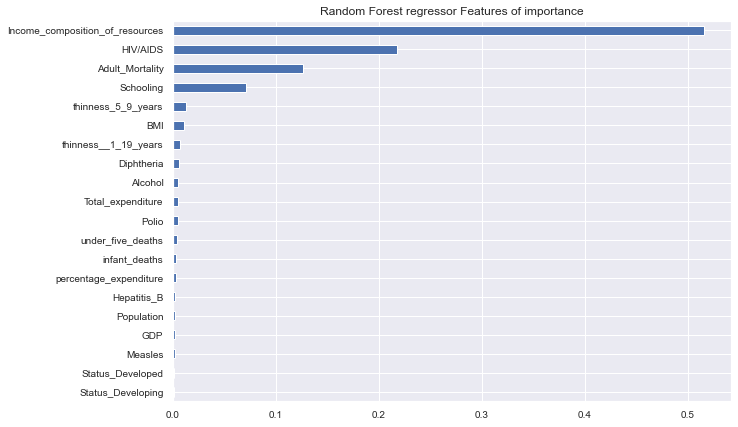

In [78]:
Important_features =  pd.Series(rf_reg4.feature_importances_, index = X_train.columns).sort_values()
Important_features.plot(kind='barh', figsize=(10,7) , fontsize=10)
plt.title('Random Forest regressor Features of importance')
plt.show()

In [79]:
# Perform K-Fold CV for Random forest regressor 
scores = cross_val_score(rf_reg4, X_train_imput_scale, y_train, cv= 5)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed whe

In [80]:
np.mean(scores)

0.9502484877866484

In [81]:
scores2 = cross_validate(rf_reg4, X_train_imput_scale, y_train, cv=5)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed whe

In [82]:
scores2 = cv_results['test_score']
np.mean(scores2), np.std(scores2)

(0.8796441263228804, 0.012124405235131887)

In [85]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1500, num = 10)]
max_features =  [x for x in np.linspace(start = 0.2, stop = 1.0, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 344, 488, 633, 777, 922, 1066, 1211, 1355, 1500], 'max_features': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 6], 'bootstrap': [True, False]}


In [86]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train_imput_scale, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': [0.2, 0.4,
                                                         0.6000000000000001,
                                                         0.8, 1.0],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=2)

In [87]:
rf_random.best_params_

{'n_estimators': 633,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 0.4,
 'max_depth': 40,
 'bootstrap': False}

In [88]:
rf_reg6 = rf_random.best_estimator_

In [89]:
predicted_train = rf_reg6.predict(X_train_imput_scale)
predicted_test = rf_reg6.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.321580965013024
MSE: 4.255165247826477
RMSE: 2.0628051890148225
R2 Square 0.9524343511465012
__________________________________
MAE: 4.3029400139787997e-13
MSE: 3.0055249644548697e-25
RMSE: 5.482266834489972e-13
R2 Square 1.0
__________________________________


In [90]:
# Perform K-Fold CV
rf_scores = cross_val_score(rf_random.best_estimator_, X_train_imput_scale, y_train, cv=5)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed whe

In [91]:
 np.mean(rf_scores), np.std(rf_scores)

(0.9615552322452239, 0.00525777010333581)

##### 1st Gradien Boosting Model 

In [92]:
grdB = GradientBoostingRegressor(n_estimators = 150, max_depth = 3, random_state=1)
grdB.fit(X_train_imput_scale, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(n_estimators=150, random_state=1)

In [93]:
predicted_train = grdB.predict(X_train_imput_scale)
predicted_test = grdB.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.7741461770760325
MSE: 6.3917435035429655
RMSE: 2.5281897681034478
R2 Square 0.9285509705630227
__________________________________
MAE: 1.1864815531020003
MSE: 2.7504461713223574
RMSE: 1.658446915436957
R2 Square 0.9697529198570076
__________________________________


#### 2nd Gradient Boost Model

In [94]:
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 150, num = 5)]
max_features =  [x for x in np.linspace(start = 0.2, stop = 1.0, num = 5)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [6, 8, 10, 12]
min_samples_leaf = [4, 6, 8, 10]
learning_rate = [x for x in np.linspace(0.01, 0.3, num = 5)]
criterion = ['mse',]


grd_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'learning_rate': learning_rate}
print(grd_grid)

{'n_estimators': [25, 56, 87, 118, 150], 'max_features': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [6, 8, 10, 12], 'min_samples_leaf': [4, 6, 8, 10], 'learning_rate': [0.01, 0.08249999999999999, 0.155, 0.22749999999999998, 0.3]}


In [95]:
# with RandomizedSearchCV
grd = GradientBoostingRegressor()

grd_Boost = RandomizedSearchCV(estimator = grd, param_distributions= grd_grid,  cv = 5, verbose=1, random_state=1, n_jobs = -1)

In [96]:
# with GridSearchCV
grd = GradientBoostingRegressor(random_state = 1)

grd_Boost2 = GridSearchCV(estimator = grd, param_grid= grd_grid, scoring='neg_mean_squared_error', cv = 5, verbose=1, n_jobs = -1)

In [97]:
grd_Boost.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01,
                                                          0.08249999999999999,
                                                          0.155,
                                                          0.22749999999999998,
                                                          0.3],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': [0.2, 0.4,
                                                         0.6000000000000001,
                                                         0.8, 1.0],
                                        'min_samples_leaf': [4, 6, 8, 10],
                                        'min_samples_split': [6, 8, 10, 12],
                                        'n_estimators': [25, 56, 87, 1

In [98]:
#grd_Boost2.fit(X_train_imput_scale, y_train)

In [99]:
grd_Boost.best_params_

{'n_estimators': 118,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 0.6000000000000001,
 'max_depth': 10,
 'learning_rate': 0.08249999999999999}

In [131]:
#grd_Boost2.best_params_

In [102]:
grd_Boost.best_estimator_

GradientBoostingRegressor(learning_rate=0.08249999999999999, max_depth=10,
                          max_features=0.6000000000000001, min_samples_leaf=8,
                          min_samples_split=10, n_estimators=118)

In [ ]:
#grd_Boost2.best_estimator_

In [103]:
GRD_Boost= grd_Boost.best_estimator_

In [ ]:
#GRD_Boost2= grd_Boost2.best_estimator_

In [104]:
predicted_train = GRD_Boost.predict(X_train_imput_scale)
predicted_test = GRD_Boost.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.3668062018559635
MSE: 4.334346416472876
RMSE: 2.0819093199447654
R2 Square 0.9515492377738611
__________________________________
MAE: 0.20911166631948802
MSE: 0.13109565035591692
RMSE: 0.3620713332423832
R2 Square 0.9985583209429594
__________________________________


In [ ]:
predicted_train = GRD_Boost2.predict(X_train_imput_scale)
predicted_test = GRD_Boost2.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

#### XGBoost regression model

In [106]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror',  learning_rate= 0.04, max_depth=5,
                       n_estimators= 200, n_jobs=-1 )
xgbr.fit(X_train_imput_scale, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.04, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
predicted_train = xgbr.predict(X_train_imput_scale)
predicted_test = xgbr.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

### 7. Mix of model, which model to select for ensemble model

In [107]:
alg= [RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), 
      DecisionTreeRegressor(), LinearRegression(), SVR(), LassoCV()]

In [108]:
for i in alg:
    model= i
    model.fit(X_train_imput_scale, y_train)
    y_pred1= model.predict(X_test_imput_scale)
    y_pred2= model.predict(X_train_imput_scale)
    print(i, model_eval(y_train, y_pred2))
    print("*"*50)
    print(i, model_eval(y_test, y_pred1))
    print("="*70)

C:\Users\HP\AppData\Local\Temp/ipykernel_49832/2741472670.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_imput_scale, y_train)


MAE: 0.4397028181041849
MSE: 0.5328801878736122
RMSE: 0.7299864299242913
R2 Square 0.9941398345049317
__________________________________
RandomForestRegressor() None
**************************************************
MAE: 1.4545392491467548
MSE: 4.7223924197952085
RMSE: 2.173106628721934
R2 Square 0.9472115308087882
__________________________________
RandomForestRegressor() None


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MAE: 2.320000771075959
MSE: 8.339383723024891
RMSE: 2.8877991140356163
R2 Square 0.9082905128471475
__________________________________
AdaBoostRegressor() None
**************************************************
MAE: 2.42969973996239
MSE: 9.689600009351022
RMSE: 3.1128122348370164
R2 Square 0.8916864364289797
__________________________________
AdaBoostRegressor() None


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MAE: 1.3112293301651572
MSE: 3.359337970305527
RMSE: 1.8328496856822512
R2 Square 0.9630568429679986
__________________________________
GradientBoostingRegressor() None
**************************************************
MAE: 1.786269291766966
MSE: 6.538506501782163
RMSE: 2.5570503518276997
R2 Square 0.9269104050779341
__________________________________
GradientBoostingRegressor() None
MAE: 0.0
MSE: 0.0
RMSE: 0.0
R2 Square 1.0
__________________________________
DecisionTreeRegressor() None
**************************************************
MAE: 2.1709897610921507
MSE: 10.114812286689421
RMSE: 3.1803792677429876
R2 Square 0.8869332725225002
__________________________________
DecisionTreeRegressor() None
MAE: 2.42219185750846
MSE: 10.749188467196358
RMSE: 3.2785955022229194
R2 Square 0.881789518940812
__________________________________
LinearRegression() None
**************************************************
MAE: 2.5268663256452206
MSE: 12.29678872564284
RMSE: 3.506677733360002
R2 Square

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MAE: 2.1009407198120638
MSE: 10.180935030726625
RMSE: 3.190757751808593
R2 Square 0.8880386894985354
__________________________________
SVR() None
**************************************************
MAE: 2.3843115506866788
MSE: 11.871431754915484
RMSE: 3.4454944137112578
R2 Square 0.8672971973224736
__________________________________
SVR() None


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MAE: 2.434873450872242
MSE: 10.798101969715463
RMSE: 3.2860465562306724
R2 Square 0.8812516096204276
__________________________________
LassoCV() None
**************************************************
MAE: 2.5459128414296908
MSE: 12.355273751021125
RMSE: 3.515006934704557
R2 Square 0.8618886509683472
__________________________________
LassoCV() None


### 7. Ensemble learning model  

In [109]:
# Train classifiers
reg1 = GradientBoostingRegressor(random_state=47)
reg2 = RandomForestRegressor(random_state=47)
reg3 = LinearRegression()

reg1.fit( X_train_imput_scale , y_train)
reg2.fit( X_train_imput_scale , y_train)
reg3.fit( X_train_imput_scale , y_train)

voting = VotingRegressor([("gb", reg1), ("rf", reg2), ("lr", reg3)])
voting.fit( X_train_imput_scale , y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\AppData\Local\Temp/ipykernel_49832/3148182653.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg2.fit( X_train_imput_scale , y_train)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=47)),
                            ('rf', RandomForestRegressor(random_state=47)),
                            ('lr', LinearRegression())])

In [111]:
predicted_train = voting.predict(X_train_imput_scale)
predicted_test = voting.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.6994047124747513
MSE: 6.26328437571216
RMSE: 2.5026554648437247
R2 Square 0.9299869293121096
__________________________________
MAE: 1.2570371988771734
MSE: 3.1402730668491654
RMSE: 1.7720815632608917
R2 Square 0.9654659334495534
__________________________________


In [ ]:
#voting.get_params()

### Selection of the best model

In [113]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost, xgbr, voting]

In [ ]:
#GRD_Boost2

In [130]:
for model in models_liste[3:]:
    model=model
    y_pred1= model.predict(X_test_imput_scale)
    y_pred2= model.predict(X_train_imput_scale)
    print(model)
    print('EVALUATION FOR TRAINING DATA SET')
    print(model_eval(y_train, y_pred2))
    print("*"*50)
    print('EVALUATION FOR TESTING DATA SET')    
    print(model_eval(y_test, y_pred1))
    print("="*70)

ElasticNet(alpha=0.0001, l1_ratio=0.4)
EVALUATION FOR TRAINING DATA SET
MAE: 2.422465123600006
MSE: 10.74930620707784
RMSE: 3.2786134580151165
R2 Square 0.8817882241372021
__________________________________
None
**************************************************
EVALUATION FOR TESTING DATA SET
MAE: 2.527914693963443
MSE: 12.300043713472308
RMSE: 3.5071418154206864
R2 Square 0.8625060306514405
__________________________________
None
DecisionTreeRegressor(max_depth=4, max_features=0.2, min_samples_leaf=0.1,
                      random_state=1)
EVALUATION FOR TRAINING DATA SET
MAE: 3.553711820842639
MSE: 23.35047910088829
RMSE: 4.832233345037085
R2 Square 0.7432111851139154
__________________________________
None
**************************************************
EVALUATION FOR TESTING DATA SET
MAE: 3.8712166019486913
MSE: 28.4318375579228
RMSE: 5.33215130673566
R2 Square 0.682179487099669
__________________________________
None
RandomForestRegressor(max_depth=4, max_features=0.4, n_esti